# タイタニック問題

kaggleの[titanic ML competition](https://www.kaggle.com/c/titanic)で与えられたデータから, 精度の高い, 乗客の生存予測モデルを構築する.

## 目次
- [事前準備](#事前準備)
  - [ライブラリ](#ライブラリ)
  - [訓練データの読み込み](#訓練データの読み込み)
- [データの可視化・外れ値/欠損値の確認](#データの可視化・外れ値/欠損値の確認)
  - [floatに変換可能か判別する関数](#floatに変換可能か判別する関数)
  - [配列に欠損値があるかどうか判別しカウントする関数](#配列に欠損値があるかどうか判別しカウントする関数)
  - [配列のユニークな値の数をカウントする関数](#配列のユニークな値の数をカウントする関数)
  - [配列の分布を表示する関数](#配列の分布を表示する関数)
  - [Pclass](#Pclass)
  - [Name](#Name)
  - [Sex](#Sex)
  - [Age](#Age)
  - [SibSp](#SibSp)
  - [Parch](#Parch)
  - [Ticket](#Ticket)
  - [Fare](#Fare)
  - [Cabin](#Cabin)
  - [Embarked](#Embarked)
- [外れ値、欠損値の扱いと特徴量の生成](#外れ値、欠損値の扱いと特徴量の生成)
  - [target_encoding関数](#target_encoding関数)
  - [show_scatter関数](#show_scatter関数)
  - [Pclassの数値変換](#Pclassの数値変換)
    - [target_encodingを適用したPclassの可視化](#target_encodingを適用したPclassの可視化)
  - [Sexの数値変換](#Sexの数値変換)
    - [target_encodingを適用したSexの可視化](#target_encodingを適用したSexの可視化)
  - [Ageの欠損値の扱いと数値変換](#Ageの欠損値の扱いと数値変換)
  - [Ageの欠損値に情報が含まれているか検証](#Ageの欠損値に情報が含まれているか検証)
    - [target_encodingを適用したAgeの可視化](#target_encodingを適用したAgeの可視化)
  - [SibSpとParchから特徴量を生成する](#SibSpとParchから特徴量を生成する)
    - [target_encodingを適用したsibSpParchの可視化](#target_encodingを適用したsibSpParchの可視化)
  - [FareにRankGaussを適応する](#FareにRankGaussを適応する)
  - [Cabinの欠損値の扱い](#Cabinの欠損値の扱い)
  - [Embarkedの欠損値の扱いと数値変換](#Embarkedの欠損値の扱いと数値変換)
    - [target_encodingを適用したembarkedの可視化](#target_encodingを適用したembarkedの可視化)
- [モデルの作成、訓練、検証](#モデルの作成、訓練、検証)
  - [generate_and_fit_model関数](#generate_and_fit_model関数)
  - [cross_validation関数](#cross_validation関数)
  - [objective関数](#objective関数)
  - [ハイパーパラメータチューニング](#ハイパーパラメータチューニング)
  - [最適化したハイパーパラメータを用いたモデルの生成](#最適化したハイパーパラメータを用いたモデルの生成)
- [テスト用データの予測](#テスト用データの予測)
  - [テスト用データの読み込み](#テスト用データの読み込み)
  - [テスト用データの加工](#テスト用データの加工)
  - [予測値の算出](#予測値の算出)
- [感想・反省](#感想・反省)

## 事前準備

### ライブラリ

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import KFold
import optuna
from functools import partial
from sklearn.preprocessing import QuantileTransformer

### 訓練データの読み込み
pandasでcsvデータを読み込み、numpyの配列に変換してunprocessed_training_dataに代入

In [2]:
unprocessed_training_data = pd.DataFrame(pd.read_csv("data/train.csv")).to_numpy()

## データの可視化・外れ値/欠損値の確認
PassengerIdとSurvivedの列は検証しない

### floatに変換可能か判別する関数

In [3]:
def is_num(num):
    try:
        float(num)
    except ValueError:
        return False
    else:
        return True

### 配列に欠損値があるかどうか判別しカウントする関数

In [4]:
def check_missing_data(array, column_name):
    if any([math.isnan(float(_)) if is_num(str(_)) else _ == "" for _ in array]):
        print(column_name + " column contains " + str(sum([int(math.isnan(float(_)) if is_num(str(_)) else _ == "") for _ in array])) + " missing value(s)")
    else:
        print(column_name + " column does not contain any missing values")

### 配列のユニークな値の数をカウントする関数

In [5]:
def count_number_of_unique_values(array, column_name):
    print(column_name + " column has " + str(np.unique(array).size) + " unique values")

### 配列の分布を表示する関数

In [6]:
def show_histogram(array, column_name):
    plt.hist(x=array)
    plt.title("Distribution of " + column_name)
    plt.xlabel(column_name)
    plt.ylabel("Frequency")
    plt.show()

### Pclass

Pclass column does not contain any missing values


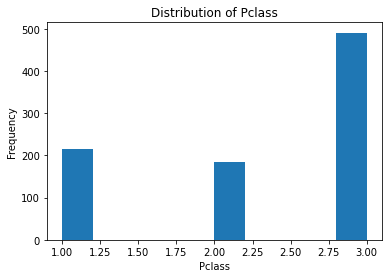

In [7]:
pClass = unprocessed_training_data[:, 2]

check_missing_data(pClass, "Pclass")

show_histogram(pClass, "Pclass")

### Name

In [8]:
name = unprocessed_training_data[:, 3]
check_missing_data(name, "Name")
count_number_of_unique_values(name, "Name")

Name column does not contain any missing values
Name column has 891 unique values


### Sex

Sex column does not contain any missing values


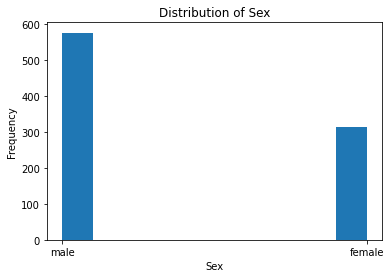

In [9]:
sex = unprocessed_training_data[:, 4]

check_missing_data([int(_ == "male") for _ in sex], "Sex")

show_histogram(sex, "Sex")

### Age

Age column contains 177 missing value(s)


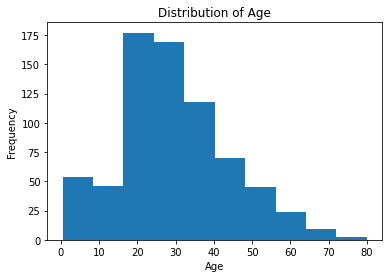

In [10]:
age = unprocessed_training_data[:, 5]

check_missing_data(age, "Age")

show_histogram(age, "Age")

### SibSp

SibSp column does not contain any missing values


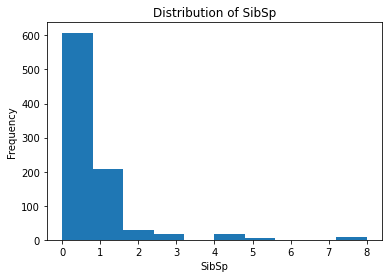

In [11]:
sibSp = unprocessed_training_data[:, 6]

check_missing_data(sibSp, "SibSp")

show_histogram(sibSp, "SibSp")

### Parch

Parch column does not contain any missing values


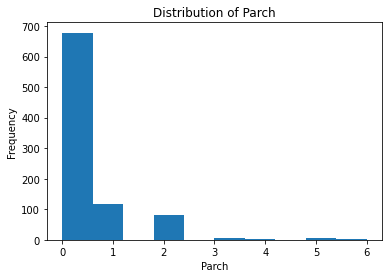

In [12]:
parch = unprocessed_training_data[:, 7]

check_missing_data(parch, "Parch")

show_histogram(parch, "Parch")

### Ticket

In [13]:
ticket = unprocessed_training_data[:, 8]
check_missing_data(ticket, "Ticket")
count_number_of_unique_values(ticket, "Ticket")

Ticket column does not contain any missing values
Ticket column has 681 unique values


### Fare

Fare column does not contain any missing values


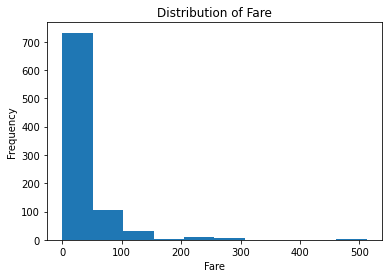

In [14]:
fare = unprocessed_training_data[:, 9]

check_missing_data(fare, "Fare")

show_histogram(fare, "Fare")

### Cabin

In [15]:
cabin = unprocessed_training_data[:, 10]
check_missing_data(cabin, "Cabin")

Cabin column contains 687 missing value(s)


### Embarked

Embarked column contains 2 missing value(s)


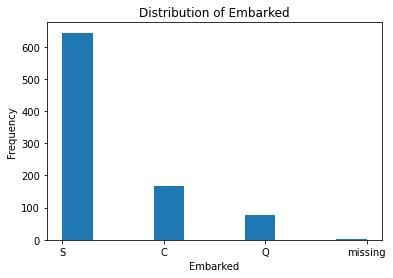

In [16]:
embarked = unprocessed_training_data[:, 11]

check_missing_data(embarked, "Embarked")

embarked[np.where(embarked != embarked)] = "missing"

show_histogram(embarked, "Embarked")

## 外れ値、欠損値の扱いと特徴量の生成

### target_encoding関数

「target_encoding」は各カテゴリ変数における目的変数の平均を用いてカテゴリ変数を数値に変換する手法である.

「target_encoding」はデータ全体から平均をとると自身の目的変数をカテゴリ変数に取り込むこと(リーク)になるので,自身の目的変数を使わないように変換する必要がある.

「target_encoding」用のfoldに分割して, 各foldごとに自身のfold以外のデータを使う「out-of-fold」の方法で目的変数の平均を求める.

In [17]:
def target_encoding(targets, categories_to_calculate_means, categories_to_process, out_of_fold):
    unique_values_of_categories = np.unique(categories_to_calculate_means)
    if out_of_fold:
        processed_categories = np.zeros(len(categories_to_calculate_means))
        kf = KFold(n_splits=5)
        for train_index_array, valid_index_array in kf.split(categories_to_calculate_means):
            average_array = [targets[train_index_array][np.where(categories_to_calculate_means[train_index_array] == unique_value)[0]].mean() for unique_value in unique_values_of_categories]
            for valid_index in valid_index_array:
                processed_categories[valid_index] = average_array[np.where(unique_values_of_categories == categories_to_calculate_means[valid_index])[0][0]]
    else:
        processed_categories = np.zeros(len(categories_to_process))
        for unique_value in unique_values_of_categories:
            processed_categories[np.where(categories_to_process == unique_value)] = targets[np.where(categories_to_calculate_means == unique_value)[0]].mean()
    return processed_categories

### show_scatter関数

In [18]:
def show_scatter(array, array2, name_of_column, name_of_column2): 
    plt.scatter(x=array , y=array2)
    plt.title("Scatter Plot of " + name_of_column + " vs "+ name_of_column2)
    plt.xlabel(name_of_column)
    plt.ylabel(name_of_column2)
    plt.grid(True)
    plt.show()

### Pclassの数値変換

Pclass列のデータに「target_encoding」を適用して特徴量を生成する.

目的変数であるSurvivedに属する値は0と1の2つの数値しかとらないので「target_encoding」に適応できる.

In [19]:
survived = unprocessed_training_data[:, 1]
processed_pClass = target_encoding(survived, pClass, [], True)

### target_encodingを適用したPclassの可視化

加工前のと加工後のデータの相関関係

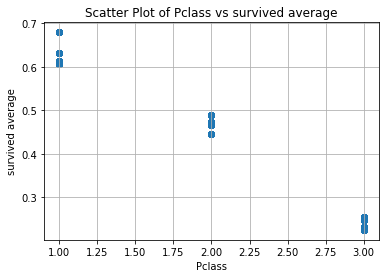

In [20]:
show_scatter(pClass, processed_pClass, "Pclass", "survived average")

### Sexの数値変換

Sex列のデータに「target_encoding」を適用して特徴量を生成する.

目的変数であるSurvivedに属する値は0と1の2つの数値しかとらないので「target_encoding」に適応できる.

In [21]:
processed_sex = target_encoding(survived, sex, [], True)

### target_encodingを適用したSexの可視化

加工前のと加工後のデータの相関関係

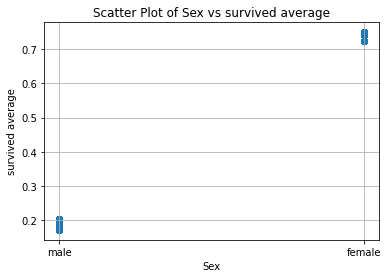

In [22]:
show_scatter(sex, processed_sex, "Sex", "survived average")

### Ageの欠損値の扱いと数値変換

データの欠損がある. その対処の候補として欠損値であることに情報が含まれていると解釈して二値変数として扱うか, 欠損値であることに情報が含まれていない場合, 欠損値を他の変数から予測するかの二択である. 

### Ageの欠損値に情報が含まれているか検証

欠損値がある場合と欠損値がない場合での目的変数の平均を可視化して, 欠損値であることに情報が含まれているか検証する.

可視化した結果, 欠損値がある場合とない場合で目的変数の平均に差があることがわかった.

よって,　欠損値であることに情報が含まれていると解釈して特徴量を生成することにした.

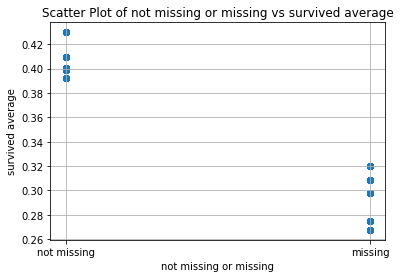

In [23]:
isMissing_arr = np.full(len(age), "not missing")

# nan != nanはTrueなのでnp.where(age != age)はageの中のnanの位置を示すインデックスの配列として扱える
isMissing_arr[np.where(age != age)] = "missing"

processed_isMissing_arr = target_encoding(survived, isMissing_arr, [], True)

show_scatter(isMissing_arr, processed_isMissing_arr, "not missing or missing", "survived average")

Ageに「binning」を適用後, 欠損値が存在するインデックスの目的変数の平均を算出.

In [24]:
number_of_bins = 8

binned_age = pd.cut(age, number_of_bins , labels = False)
binned_age[np.where(binned_age != binned_age)] = number_of_bins

processed_binned_age = target_encoding(survived, binned_age, [], True)

### target_encodingを適用したAgeの可視化

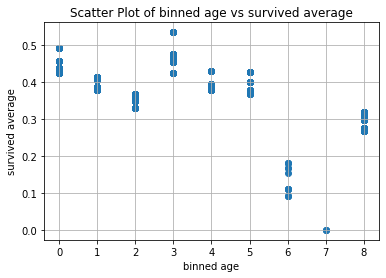

In [25]:
show_scatter(binned_age, processed_binned_age, "binned age", "survived average")

### SibSpとParchから特徴量を生成する
SibSpとParchはどちらも0かそれより大きい値を取るかの二値変数で扱い, それらを掛け合わせて特徴量を生成し, 「target_encoding」を適用する. 

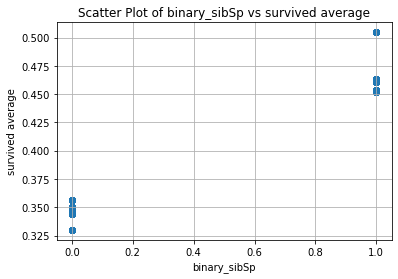

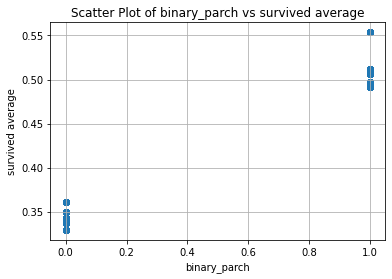

In [26]:
binary_sibSp = np.array([int(sbsp > 0) for sbsp in sibSp])

processed_binary_sibSp = target_encoding(survived, binary_sibSp, [], True)

show_scatter(binary_sibSp, processed_binary_sibSp, "binary_sibSp", "survived average")

binary_parch = np.array([int(prch > 0) for prch in parch])

processed_binary_parch = target_encoding(survived, binary_parch, [], True)

show_scatter(binary_parch, processed_binary_parch, "binary_parch", "survived average")

### target_encodingを適用したsibSpParchの可視化

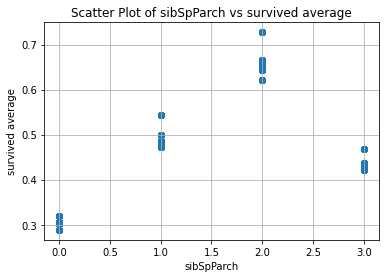

In [27]:
sibSpParch = np.array([sbsp+ prch*2 for sbsp, prch in zip(binary_sibSp, binary_parch)])

processed_sibSpParch = target_encoding(survived, sibSpParch, [], True)

show_scatter(sibSpParch, processed_sibSpParch, "sibSpParch", "survived average")

### FareにRankGaussを適応する

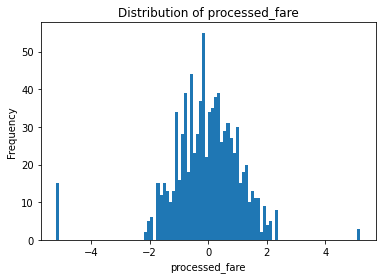

In [28]:
transformer = QuantileTransformer(n_quantiles=100, random_state=0, output_distribution="normal")
transformer.fit(fare.reshape(-1, 1))

processed_fare = transformer.transform(fare.reshape(-1, 1)).flatten()

plt.hist(x=processed_fare, bins = 100)
plt.title("Distribution of processed_fare")
plt.xlabel("processed_fare")
plt.ylabel('Frequency')
plt.show()

### Cabinの欠損値の扱い

ユニークな値と欠損値が多いので値が欠損していることに情報が含まれているか検討し, もし欠損していることに情報が含まれているなら, 欠損しているかしていないかを二値のカテゴリ変数に変換した後, 「target_encoding」を適用する.

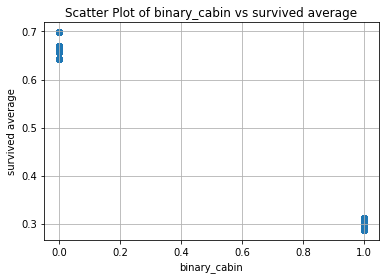

In [29]:
binary_cabin = np.zeros(len(cabin))
binary_cabin[np.where(cabin != cabin)] = 1

processed_binary_cabin = target_encoding(survived, binary_cabin, [], True)

show_scatter(binary_cabin, processed_binary_cabin, "binary_cabin", "survived average")

### Embarkedの欠損値の扱いと数値変換

欠損値が2つしか存在していない. 欠損していること自体に情報があるかがわからないので, 欠損値を平均値を使って補填したのち, 「target_encoding」を適用する.　補填に使う平均値はリークを防ぐために各foldを除外して算出している.

In [30]:
processed_embarked = target_encoding(survived, embarked, [], True)

embarked_means_list = target_encoding(survived, np.full(len(embarked), "M"), [], True)

for index in np.where(embarked == "missing"):
    processed_embarked[index] = embarked_means_list[index]

### target_encodingを適用したembarkedの可視化

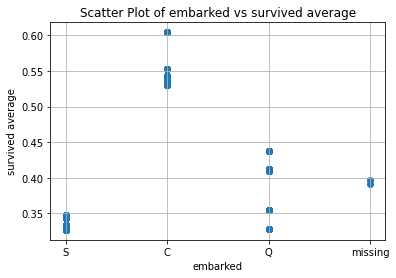

In [31]:
show_scatter(embarked, processed_embarked, "embarked", "survived average")

## モデルの作成、訓練、検証

学習モデルは全結合ニューラルネットワークを使用する.

ドロップアウト率, 中間層の数, ユニット数, 活性化関数, オプティマイザー, 学習率などのパラメータのチューニングにはベイズ最適化を用いる.

### generate_and_fit_model関数

ニューラルネットワークモデルを生成し、訓練する関数

In [32]:
def generate_and_fit_model(n_neurons, n_hidden_layers, power_of_lr, dropout_input, dropout_hidden, batch_size, x, y):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dropout(dropout_input, input_shape = (x.shape.as_list()[1],)))
    for _ in range(n_hidden_layers):
        model.add(tf.keras.layers.Dense(n_neurons, activation = 'relu'))
        model.add(tf.keras.layers.Dropout(dropout_hidden))
    model.add(tf.keras.layers.Dense(1, activation = 'sigmoid'))
    optimizer = tf.keras.optimizers.Adam(lr=10 ** (-1*power_of_lr))
    model.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
    model.fit(x, y, batch_size = batch_size, epochs = 100, verbose=0, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10, verbose=0, mode='min')])
    return model

### cross_validation関数

モデルの性能評価にクロスバリデーションを用いる. 5つのfoldに分け, それぞれ検証用のデータとして扱い, 5回求めた精度の平均値を返す.

In [33]:
def cross_validation(x, y, **args):
    n_splits = 5
    acc = np.zeros(n_splits)
    kf = KFold(n_splits=n_splits)
    index = 0
    for train_index_array, valid_index_array in kf.split(x):
        x_train_index_array = tf.convert_to_tensor([x[i] for i in train_index_array], dtype=tf.float32)
        y_train_index_array = tf.convert_to_tensor([y[i] for i in train_index_array], dtype=tf.float32)
        x_valid_index_array = tf.convert_to_tensor([x[i] for i in valid_index_array], dtype=tf.float32)
        y_valid_index_array = tf.convert_to_tensor([y[i] for i in valid_index_array], dtype=tf.float32)
        model = generate_and_fit_model(int(args['n_neurons']), int(args['n_hidden_layers']), int(args['power_of_lr']), args['dropout_input'], args['dropout_hidden'], int(args['batch_size']), x_train_index_array, y_train_index_array)
        acc[index] = model.evaluate(x_valid_index_array,  y_valid_index_array, verbose=0)[1]
        index += 1

    return float(acc.mean())

### objective関数

1から精度(0~1)を引いた値を返す. この関数はハイパーパラメータをベイズ最適化する際に, 最小化するべき目的関数となる.

In [34]:
def objective(x, y, trial):
    
    params = {
        'n_neurons' : trial.suggest_discrete_uniform('n_neurons', 8, 512, 8),
        'n_hidden_layers' : trial.suggest_discrete_uniform('n_hidden_layers', 1, 10, 1),
        'power_of_lr' : trial.suggest_discrete_uniform('power_of_lr', 1, 5, 1),
        'dropout_input' : trial.suggest_discrete_uniform('dropout_input', 0, 0.2, 0.05),
        'dropout_hidden' : trial.suggest_discrete_uniform('dropout_hidden', 0, 0.5, 0.05),
        'batch_size' : trial.suggest_discrete_uniform('batch_size', 8, 256, 8)
    }
    
    return 1.0 - cross_validation(x, y, **params)

### ハイパーパラメータチューニング

検証中, 最も高い精度を出したパラメータを採用して, モデルの訓練を行う.

In [35]:
x = tf.stack([processed_pClass, processed_sex, processed_binned_age, processed_sibSpParch, processed_fare, processed_binary_cabin, processed_embarked], axis = 1)
y = tf.convert_to_tensor(survived.reshape(-1, 1), dtype=tf.float32)

f = partial(objective, x, y)

study = optuna.create_study()

study.optimize(f, n_trials=1000)

print('params:', study.best_params)

[I 2021-04-04 07:55:59,571] A new study created in memory with name: no-name-5148a372-40dc-4f20-b815-f6b42d315931
[I 2021-04-04 07:56:15,452] Trial 0 finished with value: 0.2311531066894531 and parameters: {'n_neurons': 472.0, 'n_hidden_layers': 6.0, 'power_of_lr': 2.0, 'dropout_input': 0.15000000000000002, 'dropout_hidden': 0.25, 'batch_size': 136.0}. Best is trial 0 with value: 0.2311531066894531.
[I 2021-04-04 07:56:25,987] Trial 1 finished with value: 0.38389931917190556 and parameters: {'n_neurons': 512.0, 'n_hidden_layers': 6.0, 'power_of_lr': 1.0, 'dropout_input': 0.05, 'dropout_hidden': 0.45, 'batch_size': 120.0}. Best is trial 0 with value: 0.2311531066894531.
[I 2021-04-04 07:56:31,674] Trial 2 finished with value: 0.2345364451408386 and parameters: {'n_neurons': 16.0, 'n_hidden_layers': 6.0, 'power_of_lr': 2.0, 'dropout_input': 0.1, 'dropout_hidden': 0.15000000000000002, 'batch_size': 184.0}. Best is trial 0 with value: 0.2311531066894531.
[I 2021-04-04 07:56:59,566] Trial 3

[I 2021-04-04 08:04:36,190] Trial 28 finished with value: 0.21777666807174678 and parameters: {'n_neurons': 136.0, 'n_hidden_layers': 5.0, 'power_of_lr': 2.0, 'dropout_input': 0.15000000000000002, 'dropout_hidden': 0.0, 'batch_size': 160.0}. Best is trial 25 with value: 0.19755195379257207.
[I 2021-04-04 08:04:42,052] Trial 29 finished with value: 0.38389931917190556 and parameters: {'n_neurons': 56.0, 'n_hidden_layers': 7.0, 'power_of_lr': 1.0, 'dropout_input': 0.15000000000000002, 'dropout_hidden': 0.1, 'batch_size': 136.0}. Best is trial 25 with value: 0.19755195379257207.
[I 2021-04-04 08:04:56,887] Trial 30 finished with value: 0.24580377340316772 and parameters: {'n_neurons': 200.0, 'n_hidden_layers': 9.0, 'power_of_lr': 2.0, 'dropout_input': 0.2, 'dropout_hidden': 0.05, 'batch_size': 128.0}. Best is trial 25 with value: 0.19755195379257207.
[I 2021-04-04 08:05:11,263] Trial 31 finished with value: 0.22666499614715574 and parameters: {'n_neurons': 224.0, 'n_hidden_layers': 8.0, '

[I 2021-04-04 08:09:52,555] Trial 56 finished with value: 0.2154604315757751 and parameters: {'n_neurons': 160.0, 'n_hidden_layers': 10.0, 'power_of_lr': 3.0, 'dropout_input': 0.1, 'dropout_hidden': 0.0, 'batch_size': 144.0}. Best is trial 25 with value: 0.19755195379257207.
[I 2021-04-04 08:10:07,835] Trial 57 finished with value: 0.20538573265075688 and parameters: {'n_neurons': 128.0, 'n_hidden_layers': 10.0, 'power_of_lr': 3.0, 'dropout_input': 0.15000000000000002, 'dropout_hidden': 0.05, 'batch_size': 96.0}. Best is trial 25 with value: 0.19755195379257207.
[I 2021-04-04 08:10:32,731] Trial 58 finished with value: 0.21095976829528806 and parameters: {'n_neurons': 296.0, 'n_hidden_layers': 9.0, 'power_of_lr': 4.0, 'dropout_input': 0.15000000000000002, 'dropout_hidden': 0.0, 'batch_size': 72.0}. Best is trial 25 with value: 0.19755195379257207.
[I 2021-04-04 08:10:44,607] Trial 59 finished with value: 0.21888771057128908 and parameters: {'n_neurons': 96.0, 'n_hidden_layers': 10.0, '

[I 2021-04-04 08:16:45,559] Trial 84 finished with value: 0.22891218662261958 and parameters: {'n_neurons': 168.0, 'n_hidden_layers': 10.0, 'power_of_lr': 3.0, 'dropout_input': 0.1, 'dropout_hidden': 0.0, 'batch_size': 72.0}. Best is trial 25 with value: 0.19755195379257207.
[I 2021-04-04 08:16:58,101] Trial 85 finished with value: 0.22220827341079707 and parameters: {'n_neurons': 136.0, 'n_hidden_layers': 8.0, 'power_of_lr': 3.0, 'dropout_input': 0.15000000000000002, 'dropout_hidden': 0.0, 'batch_size': 88.0}. Best is trial 25 with value: 0.19755195379257207.
[I 2021-04-04 08:17:09,528] Trial 86 finished with value: 0.23789467811584475 and parameters: {'n_neurons': 80.0, 'n_hidden_layers': 9.0, 'power_of_lr': 3.0, 'dropout_input': 0.05, 'dropout_hidden': 0.4, 'batch_size': 112.0}. Best is trial 25 with value: 0.19755195379257207.
[I 2021-04-04 08:17:20,775] Trial 87 finished with value: 0.23228925466537476 and parameters: {'n_neurons': 120.0, 'n_hidden_layers': 10.0, 'power_of_lr': 3.

[I 2021-04-04 08:24:04,509] Trial 112 finished with value: 0.2076266527175903 and parameters: {'n_neurons': 200.0, 'n_hidden_layers': 6.0, 'power_of_lr': 3.0, 'dropout_input': 0.05, 'dropout_hidden': 0.1, 'batch_size': 56.0}. Best is trial 91 with value: 0.19414978027343754.
[I 2021-04-04 08:24:21,101] Trial 113 finished with value: 0.2165714740753174 and parameters: {'n_neurons': 248.0, 'n_hidden_layers': 7.0, 'power_of_lr': 3.0, 'dropout_input': 0.05, 'dropout_hidden': 0.05, 'batch_size': 56.0}. Best is trial 91 with value: 0.19414978027343754.
[I 2021-04-04 08:24:43,505] Trial 114 finished with value: 0.1964471817016602 and parameters: {'n_neurons': 232.0, 'n_hidden_layers': 8.0, 'power_of_lr': 3.0, 'dropout_input': 0.05, 'dropout_hidden': 0.05, 'batch_size': 32.0}. Best is trial 91 with value: 0.19414978027343754.
[I 2021-04-04 08:25:02,944] Trial 115 finished with value: 0.2042621374130249 and parameters: {'n_neurons': 272.0, 'n_hidden_layers': 8.0, 'power_of_lr': 3.0, 'dropout_in

[I 2021-04-04 08:31:57,506] Trial 140 finished with value: 0.3354779958724976 and parameters: {'n_neurons': 104.0, 'n_hidden_layers': 10.0, 'power_of_lr': 3.0, 'dropout_input': 0.2, 'dropout_hidden': 0.5, 'batch_size': 160.0}. Best is trial 91 with value: 0.19414978027343754.
[I 2021-04-04 08:32:10,902] Trial 141 finished with value: 0.21882493495941158 and parameters: {'n_neurons': 120.0, 'n_hidden_layers': 10.0, 'power_of_lr': 3.0, 'dropout_input': 0.1, 'dropout_hidden': 0.1, 'batch_size': 128.0}. Best is trial 91 with value: 0.19414978027343754.
[I 2021-04-04 08:32:21,018] Trial 142 finished with value: 0.21210219860076907 and parameters: {'n_neurons': 112.0, 'n_hidden_layers': 7.0, 'power_of_lr': 3.0, 'dropout_input': 0.1, 'dropout_hidden': 0.1, 'batch_size': 136.0}. Best is trial 91 with value: 0.19414978027343754.
[I 2021-04-04 08:32:39,689] Trial 143 finished with value: 0.21104764938354492 and parameters: {'n_neurons': 264.0, 'n_hidden_layers': 10.0, 'power_of_lr': 3.0, 'dropou

[I 2021-04-04 08:40:36,271] Trial 168 finished with value: 0.19640952348709106 and parameters: {'n_neurons': 216.0, 'n_hidden_layers': 9.0, 'power_of_lr': 3.0, 'dropout_input': 0.05, 'dropout_hidden': 0.0, 'batch_size': 104.0}. Best is trial 91 with value: 0.19414978027343754.
[I 2021-04-04 08:41:02,666] Trial 169 finished with value: 0.21212730407714842 and parameters: {'n_neurons': 232.0, 'n_hidden_layers': 10.0, 'power_of_lr': 3.0, 'dropout_input': 0.05, 'dropout_hidden': 0.0, 'batch_size': 16.0}. Best is trial 91 with value: 0.19414978027343754.
[I 2021-04-04 08:41:15,603] Trial 170 finished with value: 0.20649050474166875 and parameters: {'n_neurons': 216.0, 'n_hidden_layers': 7.0, 'power_of_lr': 3.0, 'dropout_input': 0.05, 'dropout_hidden': 0.0, 'batch_size': 104.0}. Best is trial 91 with value: 0.19414978027343754.
[I 2021-04-04 08:41:27,212] Trial 171 finished with value: 0.21209591627120972 and parameters: {'n_neurons': 80.0, 'n_hidden_layers': 9.0, 'power_of_lr': 3.0, 'dropou

[I 2021-04-04 08:48:55,082] Trial 197 finished with value: 0.20762037038803105 and parameters: {'n_neurons': 248.0, 'n_hidden_layers': 10.0, 'power_of_lr': 3.0, 'dropout_input': 0.05, 'dropout_hidden': 0.05, 'batch_size': 64.0}. Best is trial 91 with value: 0.19414978027343754.
[I 2021-04-04 08:49:08,122] Trial 198 finished with value: 0.1986881017684936 and parameters: {'n_neurons': 152.0, 'n_hidden_layers': 8.0, 'power_of_lr': 3.0, 'dropout_input': 0.15000000000000002, 'dropout_hidden': 0.1, 'batch_size': 112.0}. Best is trial 91 with value: 0.19414978027343754.
[I 2021-04-04 08:49:20,106] Trial 199 finished with value: 0.20535434484481807 and parameters: {'n_neurons': 160.0, 'n_hidden_layers': 8.0, 'power_of_lr': 3.0, 'dropout_input': 0.15000000000000002, 'dropout_hidden': 0.0, 'batch_size': 112.0}. Best is trial 91 with value: 0.19414978027343754.
[I 2021-04-04 08:49:40,445] Trial 200 finished with value: 0.2110288143157959 and parameters: {'n_neurons': 416.0, 'n_hidden_layers': 8.

[I 2021-04-04 08:56:36,874] Trial 225 finished with value: 0.20758271217346191 and parameters: {'n_neurons': 360.0, 'n_hidden_layers': 6.0, 'power_of_lr': 3.0, 'dropout_input': 0.05, 'dropout_hidden': 0.1, 'batch_size': 48.0}. Best is trial 91 with value: 0.19414978027343754.
[I 2021-04-04 08:56:52,891] Trial 226 finished with value: 0.21772645711898808 and parameters: {'n_neurons': 320.0, 'n_hidden_layers': 7.0, 'power_of_lr': 3.0, 'dropout_input': 0.1, 'dropout_hidden': 0.2, 'batch_size': 104.0}. Best is trial 91 with value: 0.19414978027343754.
[I 2021-04-04 08:57:13,538] Trial 227 finished with value: 0.20876907110214238 and parameters: {'n_neurons': 360.0, 'n_hidden_layers': 5.0, 'power_of_lr': 3.0, 'dropout_input': 0.05, 'dropout_hidden': 0.1, 'batch_size': 32.0}. Best is trial 91 with value: 0.19414978027343754.
[I 2021-04-04 08:57:27,133] Trial 228 finished with value: 0.2109660506248474 and parameters: {'n_neurons': 200.0, 'n_hidden_layers': 7.0, 'power_of_lr': 3.0, 'dropout_i

[I 2021-04-04 09:05:38,152] Trial 254 finished with value: 0.20649050474166875 and parameters: {'n_neurons': 184.0, 'n_hidden_layers': 10.0, 'power_of_lr': 3.0, 'dropout_input': 0.05, 'dropout_hidden': 0.05, 'batch_size': 80.0}. Best is trial 91 with value: 0.19414978027343754.
[I 2021-04-04 09:05:55,974] Trial 255 finished with value: 0.22112234830856325 and parameters: {'n_neurons': 168.0, 'n_hidden_layers': 10.0, 'power_of_lr': 3.0, 'dropout_input': 0.15000000000000002, 'dropout_hidden': 0.05, 'batch_size': 72.0}. Best is trial 91 with value: 0.19414978027343754.
[I 2021-04-04 09:06:13,307] Trial 256 finished with value: 0.19644091129302976 and parameters: {'n_neurons': 200.0, 'n_hidden_layers': 10.0, 'power_of_lr': 3.0, 'dropout_input': 0.05, 'dropout_hidden': 0.05, 'batch_size': 72.0}. Best is trial 91 with value: 0.19414978027343754.
[I 2021-04-04 09:06:34,202] Trial 257 finished with value: 0.21321324110031126 and parameters: {'n_neurons': 200.0, 'n_hidden_layers': 10.0, 'power_

[I 2021-04-04 09:15:24,676] Trial 283 finished with value: 0.2154604315757751 and parameters: {'n_neurons': 216.0, 'n_hidden_layers': 10.0, 'power_of_lr': 3.0, 'dropout_input': 0.05, 'dropout_hidden': 0.05, 'batch_size': 72.0}. Best is trial 91 with value: 0.19414978027343754.
[I 2021-04-04 09:15:43,055] Trial 284 finished with value: 0.21431173086166377 and parameters: {'n_neurons': 200.0, 'n_hidden_layers': 9.0, 'power_of_lr': 3.0, 'dropout_input': 0.05, 'dropout_hidden': 0.05, 'batch_size': 120.0}. Best is trial 91 with value: 0.19414978027343754.
[I 2021-04-04 09:16:01,669] Trial 285 finished with value: 0.2087251305580139 and parameters: {'n_neurons': 176.0, 'n_hidden_layers': 10.0, 'power_of_lr': 3.0, 'dropout_input': 0.05, 'dropout_hidden': 0.05, 'batch_size': 64.0}. Best is trial 91 with value: 0.19414978027343754.
[I 2021-04-04 09:16:22,937] Trial 286 finished with value: 0.2255288481712341 and parameters: {'n_neurons': 184.0, 'n_hidden_layers': 10.0, 'power_of_lr': 3.0, 'drop

[I 2021-04-04 09:24:15,144] Trial 311 finished with value: 0.2065156102180481 and parameters: {'n_neurons': 176.0, 'n_hidden_layers': 10.0, 'power_of_lr': 3.0, 'dropout_input': 0.05, 'dropout_hidden': 0.1, 'batch_size': 104.0}. Best is trial 91 with value: 0.19414978027343754.
[I 2021-04-04 09:24:32,800] Trial 312 finished with value: 0.20760781764984126 and parameters: {'n_neurons': 192.0, 'n_hidden_layers': 9.0, 'power_of_lr': 3.0, 'dropout_input': 0.05, 'dropout_hidden': 0.1, 'batch_size': 96.0}. Best is trial 91 with value: 0.19414978027343754.
[I 2021-04-04 09:24:47,542] Trial 313 finished with value: 0.21434310674667356 and parameters: {'n_neurons': 112.0, 'n_hidden_layers': 8.0, 'power_of_lr': 3.0, 'dropout_input': 0.05, 'dropout_hidden': 0.1, 'batch_size': 80.0}. Best is trial 91 with value: 0.19414978027343754.
[I 2021-04-04 09:25:27,442] Trial 314 finished with value: 0.20987384319305424 and parameters: {'n_neurons': 232.0, 'n_hidden_layers': 10.0, 'power_of_lr': 3.0, 'dropou

[I 2021-04-04 09:33:13,845] Trial 339 finished with value: 0.21097232103347774 and parameters: {'n_neurons': 192.0, 'n_hidden_layers': 10.0, 'power_of_lr': 3.0, 'dropout_input': 0.05, 'dropout_hidden': 0.05, 'batch_size': 72.0}. Best is trial 91 with value: 0.19414978027343754.
[I 2021-04-04 09:33:37,868] Trial 340 finished with value: 0.2278011441230774 and parameters: {'n_neurons': 208.0, 'n_hidden_layers': 10.0, 'power_of_lr': 3.0, 'dropout_input': 0.05, 'dropout_hidden': 0.0, 'batch_size': 96.0}. Best is trial 91 with value: 0.19414978027343754.
[I 2021-04-04 09:33:59,970] Trial 341 finished with value: 0.20311971902847292 and parameters: {'n_neurons': 184.0, 'n_hidden_layers': 10.0, 'power_of_lr': 3.0, 'dropout_input': 0.05, 'dropout_hidden': 0.05, 'batch_size': 64.0}. Best is trial 91 with value: 0.19414978027343754.
[I 2021-04-04 09:34:13,288] Trial 342 finished with value: 0.2087251305580139 and parameters: {'n_neurons': 152.0, 'n_hidden_layers': 7.0, 'power_of_lr': 3.0, 'dropo

[I 2021-04-04 09:42:53,853] Trial 367 finished with value: 0.21097232103347774 and parameters: {'n_neurons': 296.0, 'n_hidden_layers': 10.0, 'power_of_lr': 3.0, 'dropout_input': 0.05, 'dropout_hidden': 0.05, 'batch_size': 96.0}. Best is trial 91 with value: 0.19414978027343754.
[I 2021-04-04 09:43:18,359] Trial 368 finished with value: 0.2042433142662048 and parameters: {'n_neurons': 232.0, 'n_hidden_layers': 10.0, 'power_of_lr': 3.0, 'dropout_input': 0.05, 'dropout_hidden': 0.1, 'batch_size': 88.0}. Best is trial 91 with value: 0.19414978027343754.
[I 2021-04-04 09:43:32,478] Trial 369 finished with value: 0.22677798271179195 and parameters: {'n_neurons': 200.0, 'n_hidden_layers': 8.0, 'power_of_lr': 3.0, 'dropout_input': 0.05, 'dropout_hidden': 0.05, 'batch_size': 232.0}. Best is trial 91 with value: 0.19414978027343754.
[I 2021-04-04 09:43:49,716] Trial 370 finished with value: 0.23115937709808354 and parameters: {'n_neurons': 168.0, 'n_hidden_layers': 9.0, 'power_of_lr': 2.0, 'drop

[I 2021-04-04 09:51:48,696] Trial 395 finished with value: 0.2109660506248474 and parameters: {'n_neurons': 160.0, 'n_hidden_layers': 7.0, 'power_of_lr': 3.0, 'dropout_input': 0.05, 'dropout_hidden': 0.0, 'batch_size': 104.0}. Best is trial 91 with value: 0.19414978027343754.
[I 2021-04-04 09:52:04,778] Trial 396 finished with value: 0.2143493890762329 and parameters: {'n_neurons': 184.0, 'n_hidden_layers': 7.0, 'power_of_lr': 3.0, 'dropout_input': 0.05, 'dropout_hidden': 0.2, 'batch_size': 128.0}. Best is trial 91 with value: 0.19414978027343754.
[I 2021-04-04 09:52:20,214] Trial 397 finished with value: 0.20205888748168943 and parameters: {'n_neurons': 200.0, 'n_hidden_layers': 8.0, 'power_of_lr': 3.0, 'dropout_input': 0.05, 'dropout_hidden': 0.05, 'batch_size': 120.0}. Best is trial 91 with value: 0.19414978027343754.
[I 2021-04-04 09:52:39,007] Trial 398 finished with value: 0.2120770931243896 and parameters: {'n_neurons': 312.0, 'n_hidden_layers': 7.0, 'power_of_lr': 3.0, 'dropout

[I 2021-04-04 10:01:02,598] Trial 424 finished with value: 0.2143180012702942 and parameters: {'n_neurons': 232.0, 'n_hidden_layers': 9.0, 'power_of_lr': 3.0, 'dropout_input': 0.05, 'dropout_hidden': 0.05, 'batch_size': 80.0}. Best is trial 91 with value: 0.19414978027343754.
[I 2021-04-04 10:01:24,929] Trial 425 finished with value: 0.2143493890762329 and parameters: {'n_neurons': 240.0, 'n_hidden_layers': 9.0, 'power_of_lr': 3.0, 'dropout_input': 0.05, 'dropout_hidden': 0.05, 'batch_size': 80.0}. Best is trial 91 with value: 0.19414978027343754.
[I 2021-04-04 10:01:43,981] Trial 426 finished with value: 0.20765802860260008 and parameters: {'n_neurons': 224.0, 'n_hidden_layers': 9.0, 'power_of_lr': 3.0, 'dropout_input': 0.05, 'dropout_hidden': 0.05, 'batch_size': 88.0}. Best is trial 91 with value: 0.19414978027343754.
[I 2021-04-04 10:02:03,084] Trial 427 finished with value: 0.2019898414611816 and parameters: {'n_neurons': 232.0, 'n_hidden_layers': 7.0, 'power_of_lr': 3.0, 'dropout_

[I 2021-04-04 10:12:24,428] Trial 453 finished with value: 0.19869437217712405 and parameters: {'n_neurons': 240.0, 'n_hidden_layers': 8.0, 'power_of_lr': 3.0, 'dropout_input': 0.05, 'dropout_hidden': 0.0, 'batch_size': 24.0}. Best is trial 91 with value: 0.19414978027343754.
[I 2021-04-04 10:12:45,653] Trial 454 finished with value: 0.20873141288757324 and parameters: {'n_neurons': 176.0, 'n_hidden_layers': 10.0, 'power_of_lr': 3.0, 'dropout_input': 0.1, 'dropout_hidden': 0.05, 'batch_size': 152.0}. Best is trial 91 with value: 0.19414978027343754.
[I 2021-04-04 10:13:11,544] Trial 455 finished with value: 0.2143305540084839 and parameters: {'n_neurons': 216.0, 'n_hidden_layers': 10.0, 'power_of_lr': 3.0, 'dropout_input': 0.05, 'dropout_hidden': 0.05, 'batch_size': 112.0}. Best is trial 91 with value: 0.19414978027343754.
[I 2021-04-04 10:13:37,059] Trial 456 finished with value: 0.21098488569259644 and parameters: {'n_neurons': 296.0, 'n_hidden_layers': 7.0, 'power_of_lr': 3.0, 'drop

[I 2021-04-04 10:24:36,647] Trial 482 finished with value: 0.20428097248077393 and parameters: {'n_neurons': 176.0, 'n_hidden_layers': 7.0, 'power_of_lr': 3.0, 'dropout_input': 0.05, 'dropout_hidden': 0.05, 'batch_size': 96.0}. Best is trial 91 with value: 0.19414978027343754.
[I 2021-04-04 10:25:03,400] Trial 483 finished with value: 0.2031510949134827 and parameters: {'n_neurons': 200.0, 'n_hidden_layers': 10.0, 'power_of_lr': 3.0, 'dropout_input': 0.1, 'dropout_hidden': 0.05, 'batch_size': 72.0}. Best is trial 91 with value: 0.19414978027343754.
[I 2021-04-04 10:25:28,256] Trial 484 finished with value: 0.2188563227653504 and parameters: {'n_neurons': 224.0, 'n_hidden_layers': 10.0, 'power_of_lr': 3.0, 'dropout_input': 0.0, 'dropout_hidden': 0.45, 'batch_size': 88.0}. Best is trial 91 with value: 0.19414978027343754.
[I 2021-04-04 10:25:51,574] Trial 485 finished with value: 0.21546670198440554 and parameters: {'n_neurons': 208.0, 'n_hidden_layers': 7.0, 'power_of_lr': 3.0, 'dropout

[I 2021-04-04 10:38:53,002] Trial 511 finished with value: 0.20536062717437742 and parameters: {'n_neurons': 416.0, 'n_hidden_layers': 7.0, 'power_of_lr': 3.0, 'dropout_input': 0.05, 'dropout_hidden': 0.2, 'batch_size': 64.0}. Best is trial 91 with value: 0.19414978027343754.
[I 2021-04-04 10:39:21,769] Trial 512 finished with value: 0.21544159650802608 and parameters: {'n_neurons': 224.0, 'n_hidden_layers': 10.0, 'power_of_lr': 3.0, 'dropout_input': 0.05, 'dropout_hidden': 0.0, 'batch_size': 72.0}. Best is trial 91 with value: 0.19414978027343754.
[I 2021-04-04 10:39:53,780] Trial 513 finished with value: 0.22444291114807124 and parameters: {'n_neurons': 240.0, 'n_hidden_layers': 10.0, 'power_of_lr': 3.0, 'dropout_input': 0.05, 'dropout_hidden': 0.0, 'batch_size': 80.0}. Best is trial 91 with value: 0.19414978027343754.
[I 2021-04-04 10:40:38,228] Trial 514 finished with value: 0.21323834657669072 and parameters: {'n_neurons': 400.0, 'n_hidden_layers': 9.0, 'power_of_lr': 3.0, 'dropou

[I 2021-04-04 10:54:40,284] Trial 540 finished with value: 0.20760153532028203 and parameters: {'n_neurons': 216.0, 'n_hidden_layers': 10.0, 'power_of_lr': 3.0, 'dropout_input': 0.05, 'dropout_hidden': 0.1, 'batch_size': 72.0}. Best is trial 526 with value: 0.19191514253616337.
[I 2021-04-04 10:55:09,211] Trial 541 finished with value: 0.2098675608634949 and parameters: {'n_neurons': 240.0, 'n_hidden_layers': 10.0, 'power_of_lr': 3.0, 'dropout_input': 0.05, 'dropout_hidden': 0.0, 'batch_size': 88.0}. Best is trial 526 with value: 0.19191514253616337.
[I 2021-04-04 10:55:31,276] Trial 542 finished with value: 0.21657774448394773 and parameters: {'n_neurons': 208.0, 'n_hidden_layers': 9.0, 'power_of_lr': 3.0, 'dropout_input': 0.05, 'dropout_hidden': 0.05, 'batch_size': 80.0}. Best is trial 526 with value: 0.19191514253616337.
[I 2021-04-04 10:55:56,914] Trial 543 finished with value: 0.20312598943710325 and parameters: {'n_neurons': 184.0, 'n_hidden_layers': 10.0, 'power_of_lr': 3.0, 'dr

[I 2021-04-04 11:13:47,313] Trial 568 finished with value: 0.20760781764984126 and parameters: {'n_neurons': 192.0, 'n_hidden_layers': 10.0, 'power_of_lr': 3.0, 'dropout_input': 0.05, 'dropout_hidden': 0.05, 'batch_size': 56.0}. Best is trial 526 with value: 0.19191514253616337.
[I 2021-04-04 11:14:25,020] Trial 569 finished with value: 0.20428097248077393 and parameters: {'n_neurons': 184.0, 'n_hidden_layers': 10.0, 'power_of_lr': 3.0, 'dropout_input': 0.05, 'dropout_hidden': 0.05, 'batch_size': 72.0}. Best is trial 526 with value: 0.19191514253616337.
[I 2021-04-04 11:14:50,295] Trial 570 finished with value: 0.2188563227653504 and parameters: {'n_neurons': 200.0, 'n_hidden_layers': 4.0, 'power_of_lr': 3.0, 'dropout_input': 0.05, 'dropout_hidden': 0.05, 'batch_size': 88.0}. Best is trial 526 with value: 0.19191514253616337.
[I 2021-04-04 11:15:25,164] Trial 571 finished with value: 0.21099115610122676 and parameters: {'n_neurons': 216.0, 'n_hidden_layers': 9.0, 'power_of_lr': 3.0, 'd

[I 2021-04-04 11:34:16,274] Trial 597 finished with value: 0.2154604315757751 and parameters: {'n_neurons': 240.0, 'n_hidden_layers': 10.0, 'power_of_lr': 3.0, 'dropout_input': 0.05, 'dropout_hidden': 0.05, 'batch_size': 96.0}. Best is trial 579 with value: 0.18744586706161503.
[I 2021-04-04 11:34:49,261] Trial 598 finished with value: 0.19527965784072876 and parameters: {'n_neurons': 312.0, 'n_hidden_layers': 9.0, 'power_of_lr': 3.0, 'dropout_input': 0.05, 'dropout_hidden': 0.05, 'batch_size': 64.0}. Best is trial 579 with value: 0.18744586706161503.
[I 2021-04-04 11:35:29,197] Trial 599 finished with value: 0.20984872579574587 and parameters: {'n_neurons': 312.0, 'n_hidden_layers': 9.0, 'power_of_lr': 3.0, 'dropout_input': 0.05, 'dropout_hidden': 0.05, 'batch_size': 64.0}. Best is trial 579 with value: 0.18744586706161503.
[I 2021-04-04 11:36:09,947] Trial 600 finished with value: 0.20873141288757324 and parameters: {'n_neurons': 312.0, 'n_hidden_layers': 9.0, 'power_of_lr': 3.0, 'dr

[I 2021-04-04 11:56:29,507] Trial 626 finished with value: 0.19534242153167725 and parameters: {'n_neurons': 144.0, 'n_hidden_layers': 10.0, 'power_of_lr': 3.0, 'dropout_input': 0.05, 'dropout_hidden': 0.05, 'batch_size': 88.0}. Best is trial 579 with value: 0.18744586706161503.
[I 2021-04-04 11:57:02,944] Trial 627 finished with value: 0.2132195115089417 and parameters: {'n_neurons': 160.0, 'n_hidden_layers': 10.0, 'power_of_lr': 3.0, 'dropout_input': 0.1, 'dropout_hidden': 0.05, 'batch_size': 88.0}. Best is trial 579 with value: 0.18744586706161503.
[I 2021-04-04 11:57:28,511] Trial 628 finished with value: 0.21319440603256223 and parameters: {'n_neurons': 144.0, 'n_hidden_layers': 5.0, 'power_of_lr': 3.0, 'dropout_input': 0.05, 'dropout_hidden': 0.05, 'batch_size': 64.0}. Best is trial 579 with value: 0.18744586706161503.
[I 2021-04-04 11:57:56,799] Trial 629 finished with value: 0.2031510949134827 and parameters: {'n_neurons': 152.0, 'n_hidden_layers': 10.0, 'power_of_lr': 3.0, 'dr

[I 2021-04-04 12:21:12,965] Trial 655 finished with value: 0.19527965784072876 and parameters: {'n_neurons': 168.0, 'n_hidden_layers': 10.0, 'power_of_lr': 3.0, 'dropout_input': 0.05, 'dropout_hidden': 0.05, 'batch_size': 80.0}. Best is trial 579 with value: 0.18744586706161503.
[I 2021-04-04 12:21:53,380] Trial 656 finished with value: 0.2075952649116516 and parameters: {'n_neurons': 144.0, 'n_hidden_layers': 10.0, 'power_of_lr': 3.0, 'dropout_input': 0.05, 'dropout_hidden': 0.05, 'batch_size': 80.0}. Best is trial 579 with value: 0.18744586706161503.
[I 2021-04-04 12:22:35,556] Trial 657 finished with value: 0.21216496229171755 and parameters: {'n_neurons': 168.0, 'n_hidden_layers': 10.0, 'power_of_lr': 3.0, 'dropout_input': 0.1, 'dropout_hidden': 0.35000000000000003, 'batch_size': 88.0}. Best is trial 579 with value: 0.18744586706161503.
[I 2021-04-04 12:23:04,112] Trial 658 finished with value: 0.2165902972221374 and parameters: {'n_neurons': 160.0, 'n_hidden_layers': 5.0, 'power_o

[I 2021-04-04 12:56:31,434] Trial 683 finished with value: 0.21771389245986938 and parameters: {'n_neurons': 176.0, 'n_hidden_layers': 10.0, 'power_of_lr': 3.0, 'dropout_input': 0.1, 'dropout_hidden': 0.05, 'batch_size': 72.0}. Best is trial 579 with value: 0.18744586706161503.
[I 2021-04-04 12:57:24,297] Trial 684 finished with value: 0.2143493890762329 and parameters: {'n_neurons': 160.0, 'n_hidden_layers': 10.0, 'power_of_lr': 3.0, 'dropout_input': 0.05, 'dropout_hidden': 0.05, 'batch_size': 64.0}. Best is trial 579 with value: 0.18744586706161503.
[I 2021-04-04 12:58:16,379] Trial 685 finished with value: 0.19978659152984624 and parameters: {'n_neurons': 176.0, 'n_hidden_layers': 10.0, 'power_of_lr': 3.0, 'dropout_input': 0.05, 'dropout_hidden': 0.0, 'batch_size': 72.0}. Best is trial 579 with value: 0.18744586706161503.
[I 2021-04-04 12:59:05,638] Trial 686 finished with value: 0.2042621374130249 and parameters: {'n_neurons': 160.0, 'n_hidden_layers': 10.0, 'power_of_lr': 3.0, 'dr

[I 2021-04-04 13:34:06,041] Trial 712 finished with value: 0.23001695871353145 and parameters: {'n_neurons': 208.0, 'n_hidden_layers': 10.0, 'power_of_lr': 3.0, 'dropout_input': 0.05, 'dropout_hidden': 0.1, 'batch_size': 88.0}. Best is trial 579 with value: 0.18744586706161503.
[I 2021-04-04 13:35:04,427] Trial 713 finished with value: 0.20536062717437742 and parameters: {'n_neurons': 184.0, 'n_hidden_layers': 10.0, 'power_of_lr': 3.0, 'dropout_input': 0.05, 'dropout_hidden': 0.05, 'batch_size': 96.0}. Best is trial 579 with value: 0.18744586706161503.
[I 2021-04-04 13:36:09,182] Trial 714 finished with value: 0.21100999116897579 and parameters: {'n_neurons': 344.0, 'n_hidden_layers': 10.0, 'power_of_lr': 3.0, 'dropout_input': 0.05, 'dropout_hidden': 0.05, 'batch_size': 72.0}. Best is trial 579 with value: 0.18744586706161503.
[I 2021-04-04 13:37:06,692] Trial 715 finished with value: 0.1986567139625549 and parameters: {'n_neurons': 176.0, 'n_hidden_layers': 10.0, 'power_of_lr': 3.0, '

[I 2021-04-04 14:11:21,389] Trial 741 finished with value: 0.20767058134078975 and parameters: {'n_neurons': 200.0, 'n_hidden_layers': 10.0, 'power_of_lr': 3.0, 'dropout_input': 0.05, 'dropout_hidden': 0.1, 'batch_size': 80.0}. Best is trial 579 with value: 0.18744586706161503.
[I 2021-04-04 14:11:47,324] Trial 742 finished with value: 0.20092900991439822 and parameters: {'n_neurons': 176.0, 'n_hidden_layers': 5.0, 'power_of_lr': 3.0, 'dropout_input': 0.05, 'dropout_hidden': 0.05, 'batch_size': 56.0}. Best is trial 579 with value: 0.18744586706161503.
[I 2021-04-04 14:12:27,297] Trial 743 finished with value: 0.22446802854537962 and parameters: {'n_neurons': 192.0, 'n_hidden_layers': 10.0, 'power_of_lr': 3.0, 'dropout_input': 0.1, 'dropout_hidden': 0.45, 'batch_size': 80.0}. Best is trial 579 with value: 0.18744586706161503.
[I 2021-04-04 14:13:02,494] Trial 744 finished with value: 0.22104701995849607 and parameters: {'n_neurons': 208.0, 'n_hidden_layers': 6.0, 'power_of_lr': 3.0, 'dr

[I 2021-04-04 22:05:20,436] Trial 770 finished with value: 0.21214613914489744 and parameters: {'n_neurons': 264.0, 'n_hidden_layers': 10.0, 'power_of_lr': 3.0, 'dropout_input': 0.1, 'dropout_hidden': 0.1, 'batch_size': 56.0}. Best is trial 579 with value: 0.18744586706161503.
[I 2021-04-04 22:06:14,592] Trial 771 finished with value: 0.22218316793441772 and parameters: {'n_neurons': 168.0, 'n_hidden_layers': 10.0, 'power_of_lr': 3.0, 'dropout_input': 0.05, 'dropout_hidden': 0.0, 'batch_size': 72.0}. Best is trial 579 with value: 0.18744586706161503.
[I 2021-04-04 22:06:57,319] Trial 772 finished with value: 0.2064842224121094 and parameters: {'n_neurons': 216.0, 'n_hidden_layers': 9.0, 'power_of_lr': 3.0, 'dropout_input': 0.05, 'dropout_hidden': 0.05, 'batch_size': 80.0}. Best is trial 579 with value: 0.18744586706161503.
[I 2021-04-04 22:07:43,018] Trial 773 finished with value: 0.20986129045486446 and parameters: {'n_neurons': 160.0, 'n_hidden_layers': 10.0, 'power_of_lr': 3.0, 'dro

[I 2021-04-04 22:41:06,018] Trial 799 finished with value: 0.21097232103347774 and parameters: {'n_neurons': 168.0, 'n_hidden_layers': 6.0, 'power_of_lr': 3.0, 'dropout_input': 0.05, 'dropout_hidden': 0.05, 'batch_size': 72.0}. Best is trial 579 with value: 0.18744586706161503.
[I 2021-04-04 22:41:48,243] Trial 800 finished with value: 0.19531103372573855 and parameters: {'n_neurons': 184.0, 'n_hidden_layers': 9.0, 'power_of_lr': 3.0, 'dropout_input': 0.05, 'dropout_hidden': 0.15000000000000002, 'batch_size': 56.0}. Best is trial 579 with value: 0.18744586706161503.
[I 2021-04-04 22:42:38,234] Trial 801 finished with value: 0.2075952649116516 and parameters: {'n_neurons': 176.0, 'n_hidden_layers': 9.0, 'power_of_lr': 3.0, 'dropout_input': 0.05, 'dropout_hidden': 0.15000000000000002, 'batch_size': 48.0}. Best is trial 579 with value: 0.18744586706161503.
[I 2021-04-04 22:43:08,802] Trial 802 finished with value: 0.21319440603256223 and parameters: {'n_neurons': 152.0, 'n_hidden_layers':

[I 2021-04-04 23:02:43,580] Trial 827 finished with value: 0.20762037038803105 and parameters: {'n_neurons': 136.0, 'n_hidden_layers': 10.0, 'power_of_lr': 3.0, 'dropout_input': 0.05, 'dropout_hidden': 0.05, 'batch_size': 72.0}. Best is trial 579 with value: 0.18744586706161503.
[I 2021-04-04 23:03:27,816] Trial 828 finished with value: 0.20316992998123173 and parameters: {'n_neurons': 176.0, 'n_hidden_layers': 10.0, 'power_of_lr': 3.0, 'dropout_input': 0.05, 'dropout_hidden': 0.15000000000000002, 'batch_size': 88.0}. Best is trial 579 with value: 0.18744586706161503.
[I 2021-04-04 23:04:10,950] Trial 829 finished with value: 0.2166028618812561 and parameters: {'n_neurons': 200.0, 'n_hidden_layers': 10.0, 'power_of_lr': 3.0, 'dropout_input': 0.05, 'dropout_hidden': 0.05, 'batch_size': 64.0}. Best is trial 579 with value: 0.18744586706161503.
[I 2021-04-04 23:04:50,135] Trial 830 finished with value: 0.20312598943710325 and parameters: {'n_neurons': 232.0, 'n_hidden_layers': 6.0, 'power

[I 2021-04-04 23:39:44,944] Trial 855 finished with value: 0.21547926664352413 and parameters: {'n_neurons': 200.0, 'n_hidden_layers': 10.0, 'power_of_lr': 3.0, 'dropout_input': 0.05, 'dropout_hidden': 0.05, 'batch_size': 80.0}. Best is trial 579 with value: 0.18744586706161503.
[I 2021-04-04 23:41:02,083] Trial 856 finished with value: 0.20762037038803105 and parameters: {'n_neurons': 352.0, 'n_hidden_layers': 10.0, 'power_of_lr': 3.0, 'dropout_input': 0.05, 'dropout_hidden': 0.0, 'batch_size': 72.0}. Best is trial 579 with value: 0.18744586706161503.
[I 2021-04-04 23:42:17,550] Trial 857 finished with value: 0.2188437700271606 and parameters: {'n_neurons': 224.0, 'n_hidden_layers': 10.0, 'power_of_lr': 3.0, 'dropout_input': 0.05, 'dropout_hidden': 0.30000000000000004, 'batch_size': 88.0}. Best is trial 579 with value: 0.18744586706161503.
[I 2021-04-04 23:43:08,839] Trial 858 finished with value: 0.21773900985717776 and parameters: {'n_neurons': 176.0, 'n_hidden_layers': 8.0, 'power_

[I 2021-04-05 00:24:08,009] Trial 883 finished with value: 0.22217061519622805 and parameters: {'n_neurons': 200.0, 'n_hidden_layers': 10.0, 'power_of_lr': 3.0, 'dropout_input': 0.05, 'dropout_hidden': 0.05, 'batch_size': 64.0}. Best is trial 579 with value: 0.18744586706161503.
[I 2021-04-05 00:24:47,407] Trial 884 finished with value: 0.2120896458625794 and parameters: {'n_neurons': 176.0, 'n_hidden_layers': 6.0, 'power_of_lr': 3.0, 'dropout_input': 0.05, 'dropout_hidden': 0.1, 'batch_size': 72.0}. Best is trial 579 with value: 0.18744586706161503.
[I 2021-04-05 00:25:46,063] Trial 885 finished with value: 0.21100370883941655 and parameters: {'n_neurons': 168.0, 'n_hidden_layers': 10.0, 'power_of_lr': 3.0, 'dropout_input': 0.05, 'dropout_hidden': 0.1, 'batch_size': 96.0}. Best is trial 579 with value: 0.18744586706161503.
[I 2021-04-05 00:26:38,402] Trial 886 finished with value: 0.2020714402198791 and parameters: {'n_neurons': 200.0, 'n_hidden_layers': 9.0, 'power_of_lr': 3.0, 'drop

[I 2021-04-05 00:53:03,633] Trial 911 finished with value: 0.2210344672203064 and parameters: {'n_neurons': 216.0, 'n_hidden_layers': 10.0, 'power_of_lr': 3.0, 'dropout_input': 0.0, 'dropout_hidden': 0.05, 'batch_size': 72.0}. Best is trial 579 with value: 0.18744586706161503.
[I 2021-04-05 00:54:02,620] Trial 912 finished with value: 0.21886260509490962 and parameters: {'n_neurons': 160.0, 'n_hidden_layers': 9.0, 'power_of_lr': 3.0, 'dropout_input': 0.05, 'dropout_hidden': 0.05, 'batch_size': 56.0}. Best is trial 579 with value: 0.18744586706161503.
[I 2021-04-05 00:55:09,504] Trial 913 finished with value: 0.20315737724304195 and parameters: {'n_neurons': 192.0, 'n_hidden_layers': 10.0, 'power_of_lr': 3.0, 'dropout_input': 0.05, 'dropout_hidden': 0.0, 'batch_size': 96.0}. Best is trial 579 with value: 0.18744586706161503.
[I 2021-04-05 00:56:10,710] Trial 914 finished with value: 0.21098488569259644 and parameters: {'n_neurons': 168.0, 'n_hidden_layers': 10.0, 'power_of_lr': 3.0, 'dr

[I 2021-04-05 01:41:25,968] Trial 940 finished with value: 0.20534807443618774 and parameters: {'n_neurons': 208.0, 'n_hidden_layers': 10.0, 'power_of_lr': 3.0, 'dropout_input': 0.05, 'dropout_hidden': 0.05, 'batch_size': 72.0}. Best is trial 579 with value: 0.18744586706161503.
[I 2021-04-05 01:42:24,033] Trial 941 finished with value: 0.20536690950393677 and parameters: {'n_neurons': 160.0, 'n_hidden_layers': 10.0, 'power_of_lr': 3.0, 'dropout_input': 0.05, 'dropout_hidden': 0.05, 'batch_size': 80.0}. Best is trial 579 with value: 0.18744586706161503.
[I 2021-04-05 01:43:06,542] Trial 942 finished with value: 0.21097232103347774 and parameters: {'n_neurons': 120.0, 'n_hidden_layers': 6.0, 'power_of_lr': 3.0, 'dropout_input': 0.05, 'dropout_hidden': 0.05, 'batch_size': 88.0}. Best is trial 579 with value: 0.18744586706161503.
[I 2021-04-05 01:44:03,217] Trial 943 finished with value: 0.20874396562576292 and parameters: {'n_neurons': 224.0, 'n_hidden_layers': 9.0, 'power_of_lr': 3.0, '

[I 2021-04-05 02:11:04,354] Trial 968 finished with value: 0.20880045890808108 and parameters: {'n_neurons': 176.0, 'n_hidden_layers': 6.0, 'power_of_lr': 3.0, 'dropout_input': 0.1, 'dropout_hidden': 0.05, 'batch_size': 88.0}. Best is trial 579 with value: 0.18744586706161503.
[I 2021-04-05 02:12:28,857] Trial 969 finished with value: 0.21768878698349003 and parameters: {'n_neurons': 360.0, 'n_hidden_layers': 10.0, 'power_of_lr': 3.0, 'dropout_input': 0.05, 'dropout_hidden': 0.1, 'batch_size': 64.0}. Best is trial 579 with value: 0.18744586706161503.
[I 2021-04-05 02:13:26,315] Trial 970 finished with value: 0.20316364765167239 and parameters: {'n_neurons': 96.0, 'n_hidden_layers': 9.0, 'power_of_lr': 3.0, 'dropout_input': 0.05, 'dropout_hidden': 0.05, 'batch_size': 72.0}. Best is trial 579 with value: 0.18744586706161503.
[I 2021-04-05 02:14:33,146] Trial 971 finished with value: 0.20988011360168457 and parameters: {'n_neurons': 192.0, 'n_hidden_layers': 10.0, 'power_of_lr': 3.0, 'dro

[I 2021-04-05 10:07:55,641] Trial 997 finished with value: 0.2009415626525879 and parameters: {'n_neurons': 152.0, 'n_hidden_layers': 10.0, 'power_of_lr': 3.0, 'dropout_input': 0.05, 'dropout_hidden': 0.1, 'batch_size': 64.0}. Best is trial 579 with value: 0.18744586706161503.
[I 2021-04-05 10:08:56,674] Trial 998 finished with value: 0.20313854217529292 and parameters: {'n_neurons': 144.0, 'n_hidden_layers': 10.0, 'power_of_lr': 3.0, 'dropout_input': 0.05, 'dropout_hidden': 0.1, 'batch_size': 96.0}. Best is trial 579 with value: 0.18744586706161503.
[I 2021-04-05 10:09:58,826] Trial 999 finished with value: 0.24009792804718022 and parameters: {'n_neurons': 160.0, 'n_hidden_layers': 10.0, 'power_of_lr': 3.0, 'dropout_input': 0.05, 'dropout_hidden': 0.1, 'batch_size': 88.0}. Best is trial 579 with value: 0.18744586706161503.


params: {'n_neurons': 232.0, 'n_hidden_layers': 10.0, 'power_of_lr': 3.0, 'dropout_input': 0.05, 'dropout_hidden': 0.05, 'batch_size': 80.0}


### 最適化したハイパーパラメータを用いたモデルの生成

In [36]:
model = generate_and_fit_model(int(study.best_params['n_neurons']), int(study.best_params['n_hidden_layers']), int(study.best_params['power_of_lr']), study.best_params['dropout_input'], study.best_params['dropout_hidden'], int(study.best_params['batch_size']), x, y)

## テスト用データの予測

### テスト用データの読み込み

In [37]:
unprocessed_data = pd.DataFrame(pd.read_csv("data/test.csv")).to_numpy()
pClass_test = unprocessed_data[:, 1]
sex_test = unprocessed_data[:, 3]
age_test = unprocessed_data[:, 4]
sibSp_test = unprocessed_data[:, 5]
parch_test = unprocessed_data[:, 6]
fare_test = unprocessed_data[:, 8]
cabin_test = unprocessed_data[:, 9]
embarked_test = unprocessed_data[:, 10]
embarked_test[np.where(embarked_test != embarked_test)] = "missing"

### テスト用データの加工

In [38]:
processed_pClass_test = target_encoding(survived, pClass, pClass_test, False)
processed_sex_test = target_encoding(survived, sex, sex_test, False)
number_of_bins = 8
binned_age_test = pd.cut(age_test, number_of_bins , labels = False)
binned_age_test[np.where(binned_age_test != binned_age_test)] = number_of_bins
processed_binned_age_test = target_encoding(survived, binned_age, binned_age_test, False)
binary_sibSp_test = np.array([int(sbsp > 0) for sbsp in sibSp_test])
binary_parch_test = np.array([int(prch > 0) for prch in parch_test])
sibSpParch_test = np.array([sbsp+ prch*2 for sbsp, prch in zip(binary_sibSp_test, binary_parch_test)])
processed_sibSpParch_test = target_encoding(survived, sibSpParch, sibSpParch_test, False)
transformer_test = QuantileTransformer(n_quantiles=100, random_state=0, output_distribution="normal")
transformer_test.fit(fare_test.reshape(-1, 1))
processed_fare_test = transformer_test.transform(fare_test.reshape(-1, 1)).flatten()
binary_cabin_test = np.zeros(len(cabin_test))
binary_cabin_test[np.where(cabin_test != cabin_test)] = 1
processed_binary_cabin_test = target_encoding(survived, binary_cabin, binary_cabin_test, False)
processed_embarked_test = target_encoding(survived, embarked, embarked_test, False)
embarked_test_means_list = target_encoding(survived, np.full(len(embarked), "M"), embarked_test, True)
for index in np.where(embarked_test == "missing"):
    processed_embarked_test[index] = embarked_test_means_list[index]

### 予測値の算出

kaggleに予測値を提出したところ, 精度は0.77272であった.

In [39]:
x = tf.stack(
    [processed_pClass_test, 
     processed_sex_test,
     processed_binned_age_test, 
     processed_sibSpParch_test,
     processed_fare_test, 
     processed_binary_cabin_test, 
     processed_embarked_test], 
    axis = 1)


predictions = model.predict(x)

passengerId = unprocessed_data[:, 0]
binary_predictions = np.array([int(prdctn >= 0.5) for prdctn in predictions])

labels = np.array(["PassengerId", "Survived"])

predictions_with_passengerId = np.stack((passengerId, binary_predictions), axis=-1)

labeled_predictions_with_passengerId = np.insert(predictions_with_passengerId, 0, labels, axis=0)

print(labeled_predictions_with_passengerId)

np.savetxt(
    "data/predictions.csv",
    labeled_predictions_with_passengerId,
    fmt='%s',
    delimiter=","
)

[['PassengerId' 'Survived']
 [892 0]
 [893 0]
 [894 0]
 [895 0]
 [896 0]
 [897 0]
 [898 1]
 [899 0]
 [900 1]
 [901 0]
 [902 0]
 [903 0]
 [904 1]
 [905 0]
 [906 1]
 [907 1]
 [908 0]
 [909 0]
 [910 1]
 [911 1]
 [912 0]
 [913 0]
 [914 1]
 [915 0]
 [916 1]
 [917 0]
 [918 1]
 [919 0]
 [920 0]
 [921 0]
 [922 0]
 [923 0]
 [924 0]
 [925 0]
 [926 0]
 [927 0]
 [928 1]
 [929 0]
 [930 0]
 [931 0]
 [932 0]
 [933 0]
 [934 0]
 [935 1]
 [936 1]
 [937 0]
 [938 0]
 [939 0]
 [940 1]
 [941 0]
 [942 0]
 [943 0]
 [944 1]
 [945 1]
 [946 0]
 [947 0]
 [948 0]
 [949 0]
 [950 0]
 [951 1]
 [952 0]
 [953 0]
 [954 0]
 [955 1]
 [956 0]
 [957 1]
 [958 1]
 [959 0]
 [960 0]
 [961 1]
 [962 1]
 [963 0]
 [964 1]
 [965 0]
 [966 1]
 [967 0]
 [968 0]
 [969 1]
 [970 0]
 [971 1]
 [972 0]
 [973 0]
 [974 0]
 [975 0]
 [976 0]
 [977 0]
 [978 1]
 [979 1]
 [980 1]
 [981 0]
 [982 0]
 [983 0]
 [984 1]
 [985 0]
 [986 0]
 [987 0]
 [988 1]
 [989 0]
 [990 1]
 [991 0]
 [992 1]
 [993 0]
 [994 0]
 [995 0]
 [996 1]
 [997 0]
 [998 0]
 [999 0]


## 感想・反省

kaggleのチュートリアルであるtitanicの生存者予測のモデル生成をこれを以って完了.

事前にtitanicの特徴量生成などの記事を読まずに[Kaggleで勝つデータ分析の技術](https://www.amazon.com/Kaggle%E3%81%A7%E5%8B%9D%E3%81%A4%E3%83%87%E3%83%BC%E3%82%BF%E5%88%86%E6%9E%90%E3%81%AE%E6%8A%80%E8%A1%93/dp/4297108437/ref=sr_1_6?dchild=1&keywords=kaggle+%E5%8B%9D%E3%81%A4&qid=1617488435&sr=8-6)という本の知識を用いてモデルを生成した.

 工夫した点として, target_encodingで加工されたデータと加工される前のデータを二次元上にプロットした図を用意したことがあげられる.
 
 そのように図で表すことで各データがどれくらい生存率と関連があるのか, 各カテゴリ毎でそれぞれどれくらいの生存率の乖離があるか調べることができた.
 
 また, 欠損値であること自体に意味があると検証で明らかにして, うまいこと欠損値を特徴量にすることができた.
 
 反省点としては, nameやticketなどの非構造化データの扱いを断念してしまったことがあげられる.
 
 nameに関して, masterやMrs. Ms. Mr.などの文字列が含まれていることに意味があると見抜けなかった.
 
 kaggle competition自体, 初めての試みであったが, 若干平均(0.769)の精度を上回る0.77272という値を出したことが素直に喜ばしい.